<a href="https://colab.research.google.com/github/masies/AI/blob/master/PreProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PRE_PROCESSING


In [1]:
from google.colab import auth
auth.authenticate_user()
project_id = 'helical-loop-303918'
bucket_name = 'code_review_automation'
!gcloud config set project {project_id}

Updated property [core/project].


In [2]:
!pip install sentencepiece
!pip3 install pip install transformers

import json
import pickle
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sentencepiece as spm
import re
import unicodedata

!pip install nltk
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Import java codeSearchNet and stackoverflow archives + cleaning

In [ ]:
!gsutil cp gs://{bucket_name}/raw_data/java_dedupe_definitions_v2.pkl ./java_dedupe_definitions_v2.pkl
!gsutil cp gs://{bucket_name}/raw_data/stackoverflow.csv ./stackoverflow.csv

Copying gs://code_review_automation/raw_data/java_dedupe_definitions_v2.pkl...
- [1 files][  3.6 GiB/  3.6 GiB]   46.4 MiB/s                                   
Operation completed over 1 objects/3.6 GiB.                                      
Copying gs://code_review_automation/raw_data/stackoverflow.csv...
\ [1 files][883.4 MiB/883.4 MiB]   48.8 MiB/s                                   
Operation completed over 1 objects/883.4 MiB.                                    


In [ ]:
stackOverflowArchive = open("stackoverflow.csv", "r")
answers = stackOverflowArchive.readlines()
stackOverflowArchive.close()

answers = answers

# remove bunch of markdown trash

answers = [x.strip()
				  .replace("&#xA;",'')
          .replace("\t"," ")
				  .replace("&gt;",'>')
				  .replace("&lt;",'<')
				  .replace("<em>",' ')
				  .replace("</em>",' ')
				  .replace("<blockquote>",' ')
				  .replace("</blockquote>",' ')
				  .replace("<p>",' ')
				  .replace("</p>",' ')
				  .replace("<ol>",' ')
				  .replace("</ol>",' ')
				  .replace("<li>",' ')
				  .replace("</li>",' ')
				  .replace("<ul>",' ')
				  .replace("</ul>",' ')
				  .replace("<strong>",' ')
				  .replace("</strong>",' ')
				  .replace("<code>",' ')
				  .replace("</code>",' ')
				  .replace("<pre>",' ')
				  .replace("</pre>",' ')
				  .replace("<h1>",' ')
				  .replace("</h1>",' ')
				  .replace("<h2>",' ')
				  .replace("</h2>",' ')
				  .replace("<h3>",' ')
				  .replace("</h3>",' ')
				  .replace("<h4>",' ')
				  .replace("</h4>",' ')
				  .replace("<h5>",' ')
				  .replace("</h5>",' ')
				  .replace("<h6>",' ')
				  .replace("</h6>",' ')
				  .replace("<hr>",' ')
				  .replace("<br>",' ')
          .replace("</s>",' ')
          .replace("<s>",' ')
				  [1:-1] for x in answers ]

# remove links tags
regex_a_open = re.compile(r"<\s*a href[^>]*>", re.IGNORECASE)
regex_a_close = re.compile(r"<\s*\/\s*a>", re.IGNORECASE)
answers = [regex_a_open.sub(r'',x) for x in answers]
answers = [regex_a_close.sub(r'',x) for x in answers]

# remove extra spaces
answers = [" ".join(x.split()) for x in answers ]

clean_answer_list = []
for i in range(len(answers)):
  line = answers[i]
  number_of_tokens = len(word_tokenize(line))
  if number_of_tokens >= 5 and number_of_tokens <= 512 :
    clean_answer_list.append(line)
  if (i % 10000 == 0):
    print("completed " + str(round(i/len(answers),2)))
len(clean_answer_list)

with open('./pretraining_so.txt', 'w') as f:
    for line in clean_answer_list:
        f.write("%s\n" % line)

completed 0.0
completed 0.01
completed 0.03
completed 0.04
completed 0.05
completed 0.06
completed 0.08
completed 0.09
completed 0.1
completed 0.11
completed 0.13
completed 0.14
completed 0.15
completed 0.16
completed 0.18
completed 0.19
completed 0.2
completed 0.21
completed 0.23
completed 0.24
completed 0.25
completed 0.27
completed 0.28
completed 0.29
completed 0.3
completed 0.32
completed 0.33
completed 0.34
completed 0.35
completed 0.37
completed 0.38
completed 0.39
completed 0.4
completed 0.42
completed 0.43
completed 0.44
completed 0.45
completed 0.47
completed 0.48
completed 0.49
completed 0.5
completed 0.52
completed 0.53
completed 0.54
completed 0.56
completed 0.57
completed 0.58
completed 0.59
completed 0.61
completed 0.62
completed 0.63
completed 0.64
completed 0.66
completed 0.67
completed 0.68
completed 0.69
completed 0.71
completed 0.72
completed 0.73
completed 0.74
completed 0.76
completed 0.77
completed 0.78
completed 0.8
completed 0.81
completed 0.82
completed 0.83
co

In [ ]:
CodeSearchNet = open('./java_dedupe_definitions_v2.pkl', 'rb')
# dump information to that file
data = pickle.load(CodeSearchNet)
CodeSearchNet.close

<function BufferedReader.close>

In [ ]:
dataset = []

def cleanString(s):
    # return "".join(ch for ch in s if unicodedata.category(ch)[0]!="C")
    s = s.replace("\n",' ').replace("\t",' ').replace("</s>",' ').replace("<s>",' ')
    
    s = " ".join(s.split())
    return s

def isAscii(s):
    return all(ord(c) < 128 for c in s)

for entry in data:
  code = cleanString(entry['function'].strip())
  comment = cleanString(entry['docstring'].strip())

  code_len = len(word_tokenize(code))
  comment_len = len(word_tokenize(comment))

  if (comment_len <= 10):
    continue
  
  if (code_len <= 5):
    continue

  if not (isAscii(comment)):
    continue

  if not (' ' in comment):
    continue
    
  if (code_len + comment_len <= 512):
    dataset.append([code, comment, code_len, comment_len])


codeSearchNetDataset = [line[1] + " " + line[0] for line in dataset]
with open('./pretraining_csn.txt', 'w') as f:
    for line in codeSearchNetDataset:
        f.write("%s\n" % line)

In [ ]:
final_dataset = codeSearchNetDataset + clean_answer_list 
with open('./pretraining.txt', 'w') as f:
    for line in final_dataset:
        f.write("%s\n" % line)

In [ ]:
!gsutil cp ./pretraining_so.txt  gs://{bucket_name}/dataset/pretraining_so.txt
!gsutil cp ./pretraining_csn.txt  gs://{bucket_name}/dataset/pretraining_csn.txt
!gsutil cp ./pretraining.txt  gs://{bucket_name}/dataset/pretraining.txt

Copying file://./pretraining_so.txt [Content-Type=text/plain]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

|
Operation completed over 1 objects/492.8 MiB.                                    
Copying file://./pretraining_csn.txt [Content-Type=text/plain]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable par

## Some stats about our java data

2324 number of entries

473.00 max code length
18.00 min code length
74.42 mean code length
53.00 median code length
61.14 std code length

458.00 max Comment length
11.00 min Comment length
63.95 mean comment length
44.00 median comment length
61.92 std comment length
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

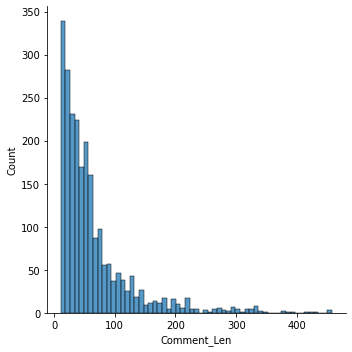

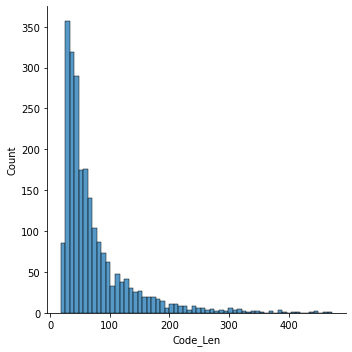

In [ ]:
pd.set_option('display.max_colwidth', None)

df = pd.DataFrame(dataset, columns =['Code', 'Comment', 'Code_Len', 'Comment_Len']) 
df_eligible = df[(df['Code_Len']+df['Comment_Len'] < 512)]
sns.displot(df_eligible["Comment_Len"])
sns.displot(df_eligible["Code_Len"])
df_eligible

print(len(df),"number of entries")
print()

print("%.2f" % df["Code_Len"].max(), "max code length")
print("%.2f" % df["Code_Len"].min(), "min code length")

print("%.2f" % df["Code_Len"].mean(), "mean code length")
print("%.2f" % df["Code_Len"].median(), "median code length")
print("%.2f" % df["Code_Len"].std(), "std code length")

print()
print("%.2f" % df["Comment_Len"].max(), "max Comment length")
print("%.2f" % df["Comment_Len"].min(), "min Comment length")

print("%.2f" % df["Comment_Len"].mean(), "mean comment length")
print("%.2f" % df["Comment_Len"].median(), "median comment length")
print("%.2f" % df["Comment_Len"].std(), "std comment length")


print(df.loc[df['Code_Len'] == df['Code_Len'].max()])
print(df.loc[df['Code_Len'] == df['Code_Len'].min()])


## IF WE DO NOT NEED TO PROCESS RAW DATA WE CAN JUST EXECUTE THIS

In [ ]:
!gsutil cp gs://{bucket_name}/dataset/pretraining_so.txt ./pretraining_so.txt  
!gsutil cp gs://{bucket_name}/dataset/pretraining_csn.txt ./pretraining_csn.txt  

lines_so = []
lines_csn = []

with open('./pretraining_so.txt') as f:
    lines_so = f.read().splitlines()

with open('./pretraining_csn.txt') as f:
    lines_csn = f.read().splitlines()

lines = lines_so + lines_csn

with open('./pretraining.txt', 'w') as f:
    for line in lines:
        f.write("%s\n" % line)

Copying gs://code_review_automation/dataset/pretraining_so.txt...
| [1 files][492.8 MiB/492.8 MiB]                                                
Operation completed over 1 objects/492.8 MiB.                                    
Copying gs://code_review_automation/dataset/pretraining_csn.txt...
\ [1 files][272.8 MiB/272.8 MiB]                                                
Operation completed over 1 objects/272.8 MiB.                                    


## preparing pre-processing

In [3]:
!gsutil cp gs://{bucket_name}/dataset/pretraining.txt ./pretraining.txt

Copying gs://code_review_automation/dataset/pretraining.txt...
\ [1 files][768.0 MiB/768.0 MiB]   45.0 MiB/s                                   
Operation completed over 1 objects/768.0 MiB.                                    


In [4]:
!wc -l ./pretraining.txt

1166811 ./pretraining.txt


In [5]:
spm.SentencePieceTrainer.train('--input=./pretraining.txt --model_prefix=TestModel --hard_vocab_limit=false --vocab_size=32000 --bos_id=-1 --eos_id=1 --unk_id=2 --pad_id=0')

In [6]:
!gsutil cp ./TestModel.model gs://{bucket_name}/models/TestModel.model
!gsutil cp ./TestModel.vocab gs://{bucket_name}/vocab/TestModel.vocab

Copying file://./TestModel.model [Content-Type=application/octet-stream]...
/ [1 files][764.7 KiB/764.7 KiB]                                                
Operation completed over 1 objects/764.7 KiB.                                    
Copying file://./TestModel.vocab [Content-Type=application/octet-stream]...
/ [1 files][560.4 KiB/560.4 KiB]                                                
Operation completed over 1 objects/560.4 KiB.                                    


In [7]:
!gsutil cp gs://{bucket_name}/utils/T5-masking.py ./T5-masking.py
!python3 ./T5-masking.py --train_data_file ./pretraining.txt --tokenizer_name ./TestModel.model --save_folder .

Copying gs://code_review_automation/utils/T5-masking.py...
/ [1 files][  6.8 KiB/  6.8 KiB]                                                
Operation completed over 1 objects/6.8 KiB.                                      
Calling T5Tokenizer.from_pretrained() with the path to a single file or url is deprecated
  0% 0/1166811 [00:00<?, ?it/s]2021-02-23 15:06:14.497079: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
100% 1166811/1166811 [5:09:29<00:00, 62.84it/s]


creation of the dataframe for exporting .tsv file 


In [8]:
df_list_inputs = [] 
with open("./train_inputs.txt","r") as f:
  for line in f:
    df_list_inputs.append(line)

df_list_labels = [] 
with open("./train_labels.txt","r") as f:
  for line in f:
    df_list_labels.append(line)

df = pd.DataFrame()
df['Inputs']  = df_list_inputs
df['Labels']  = df_list_labels

# df.to_csv(path_or_buf='./pre-training.tsv', sep='\t', header=False, index=False, index_label=False)

f = open("./pre-training.tsv", "w")
for index, row in df.iterrows():
  f.write(row['Inputs'].strip() + "\t" + row['Labels'].strip() + "\n" )
f.close()

In [9]:
!gsutil cp ./pre-training.tsv  gs://{bucket_name}/dataset/pre-training.tsv
! head -6 ./pre-training.tsv
! wc -l pre-training.tsv

Copying file://./pre-training.tsv [Content-Type=text/tab-separated-values]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/
Operation completed over 1 objects/1.4 GiB.                                      
Bind indexed elements<extra_id_0> the supplied<extra_id_1> .<extra_id_2> param name the name<extra_id_3> the property to bind @param target the target bindable @<

# PRETRAINING

In [10]:
!awk 'NR >= 900000 && NR <= 900100' ./pre-training.tsv

Your containers (Swing vs. JavaFX) have different background colors, so the color<extra_id_0> shines through<extra_id_1> transparent component is<extra_id_2> . I slightly<extra_id_3> run() method<extra_id_4> @Overridepublic void run() {<extra_id_5> new Pane(); contents.setBackground(new Background( new BackgroundFill<extra_id_6> jfxColour<extra_id_7> new<extra_id_8> CornerRadii(0), new Insets(0))));<extra_id_9> scene = new Scene(contents<extra_id_10> jfxPanel.setScene(scene);} This still<extra_id_11> the issue. However, if I now<extra_id_12> the Scene background<extra_id_13> to BLACK , the colors are rendered the<extra_id_14> : @Overridepublic void<extra_id_15> () { Pane contents = new Pane<extra_id_16> contents.setBackground(new<extra_id_17> (<extra_id_18> BackgroundFill(jfxColour, new CornerRadii(0), new<extra_id_19> (0)))<extra_id_20> //<extra_id_21> scene = new Scene(contents);<extra_id_22> scene = new<extra_id_23> contents, javafx.<extra_id_24> .<extra_id_25> .Color.BLACK); // !!!